[Bonne segmentation des clients](https://www.kaggle.com/code/farrasalyafi/eda-customer-segmentatioin)


In [363]:
url = 'https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/download'
zip_file_name = 'brazilian-e-commerce-dataset.zip'
extract_name = 'olist_customers_dataset.csv'
dl_path = 'downloads'
zip_file_path = f'./{dl_path}/{zip_file_name}'
extracts_path = 'extracts'
extract_to_path = f'./{extracts_path}/{extract_name}'

In [364]:
if os.path.isfile(zip_file_path):
    print('File already downloaded')
else:
    # Create the downloads folder
    os.makedirs(dl_path)

    # Download file from url
    import urllib.request
    urllib.request.urlretrieve(url, zip_file_path)
    print('File downloaded')

if os.path.isfile(extract_to_path):
    print('File already extracted')
else:
    # Unzip file
    import zipfile
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracts_path)
    print('Files extracted')

File already downloaded
File already extracted


Using this schema to navigate between the different datasets :
![dataset_relation_schema](https://i.imgur.com/HRhd2Y0.png)

As we have to segment clients profiles, we will mostly use the client dataset (olist_order_customer_dataset) related to others.

# Exploration

In order to avoid to explore every dataset, we will do only for data_customer then add a dataset to the exploration part every time we need one.

## Retrieving the data

In [365]:
import pandas as pd

# Reading all the files
raw_path = './extracts/'
data_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
data_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
data_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
data_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
data_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
data_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
data_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
data_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')
data_category = pd.read_csv(raw_path + 'product_category_name_translation.csv')

In [366]:
#Menggabungkan semua data-data 
all_data = data_orders.merge(data_order_items, on='order_id', how='left')
all_data = all_data.merge(data_order_payments, on='order_id', how='inner')
all_data = all_data.merge(data_order_reviews, on='order_id', how='inner')
all_data = all_data.merge(data_products, on='product_id', how='inner')
all_data = all_data.merge(data_customer, on='customer_id', how='inner')
all_data = all_data.merge(data_sellers, on='seller_id', how='inner')
all_data = all_data.merge(data_category,on='product_category_name',how='inner')
all_data.dtypes

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
review_id                         object
review_score                       int64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp           object
product_category

## 1st : data_customer

### Shape

- `customer_id` : key to the orders dataset. Each order has a unique customer_id.
- `customer_unique_id` : unique identifier of a customer.
- `customer_zip_code_prefix` : first five digits of customer zip code.
- `customer_city` : customer city name.
- `customer_state` : customer state.

In [367]:
print(data_customer.dtypes)
data_customer.head()

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


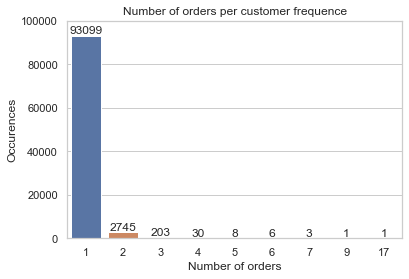

In [368]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

number_of_orders = Counter(data_customer['customer_unique_id'].value_counts().values)
pd_number_of_orders = pd.DataFrame(number_of_orders.items(), columns=['number_of_order_per_customer', 'occurences'])
# keys = number_of_orders.keys()
# values = number_of_orders.values()

ax = sns.barplot(x='number_of_order_per_customer', y = 'occurences', data = pd_number_of_orders)
ax.set(xlabel='Number of orders', ylabel='Occurences')
ax.set_title('Number of orders per customer frequence')
ax.set_ylim(0, 100000)
ax.bar_label(ax.containers[0])
plt.show()

In [369]:
data_customer[data_customer.isnull().sum(axis=1) != 0]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


No missing values.

### Oultiers

Ids seemed to be in hex with a length of 32, we check that they all fulfill this condition.

In [370]:
import string

if data_customer.loc[data_customer['customer_unique_id'].str.len() != 32,:].shape[0] == 0:
    print('All the customer_unique_id are 32 characters long')
else:
    print('There are some customer_unique_id which are not 32 characters long')

try:
    data_customer['customer_unique_id'].apply(int, base=16)
    print('All the customer_unique_id are in base 16')
except:
    print('There are some customer_unique_id which are not in base 16')
    
if data_customer.loc[data_customer['customer_id'].str.len() != 32,:].shape[0] == 0:
    print('All the customer_id are 32 characters long')
else:
    print('There are some customer_id which are not 32 characters long')

try:
    data_customer['customer_id'].apply(int, base=16)
    print('All the customer_id are in base 16')
except:
    print('There are some customer_id which are not in base 16')

All the customer_unique_id are 32 characters long
All the customer_unique_id are in base 16
All the customer_id are 32 characters long
All the customer_id are in base 16


The other columns on the dataset are not interesting.

## 2nd : data_orders

### Shape

- `order_id` : unique identifier of the order.
- `customer_id` : key to the customer dataset. Each order has a unique customer_id.
- `order_status` : Reference to the order status (delivered, shipped, etc).
- `order_purchase_timestamp` : Shows the purchase timestamp.
- `order_approved_at` : Shows the payment approval timestamp.
- `order_delivered_carrier_date` : Shows the order posting timestamp. When it was handled to the logistic partner..
- `order_delivered_customer_date` : Shows the actual order delivery date to the customer.
- `order_estimated_delivery_date` : Shows the estimated delivery date that was informed to customer at the purchase moment.

In [371]:
print(data_orders.dtypes)
data_orders.head()

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


There are a lot of dates in this dataframe, we will check their distribution by grouping them per month.

Figure(864x1080)


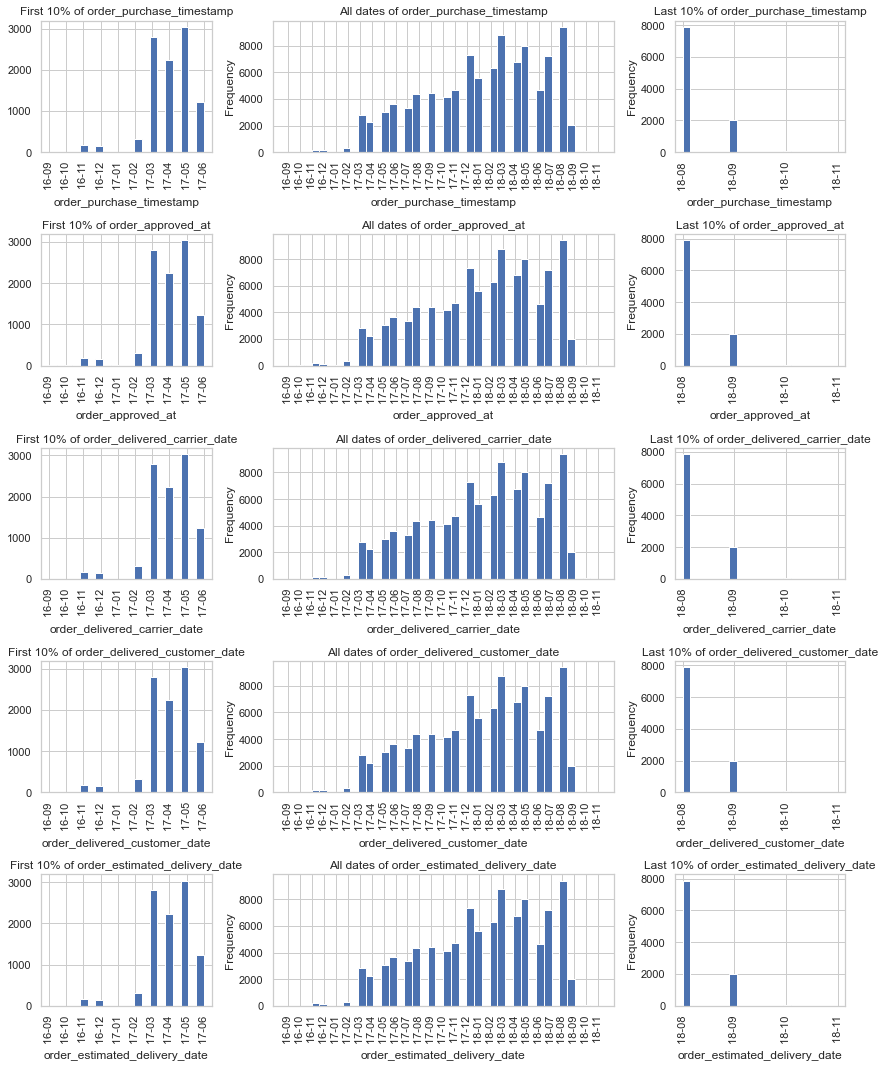

In [372]:
data_orders_date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
data_order_visualization = data_orders[data_orders_date_columns]


fig, axs = plt.subplots(len(data_orders_date_columns),3,gridspec_kw={'width_ratios': [2, 4, 2]}, figsize=(12,15))

for i, columns in enumerate(data_orders_date_columns):
    
    sorted_dates = pd.to_datetime(data_order_visualization[column]).dt.strftime(' %y-%m')
    sorted_dates = sorted_dates.sort_values(ascending=True)
    hundred_first_dates = sorted_dates.head(round(len(sorted_dates)*0.1))
    hundred_last_dates = sorted_dates.tail(round(len(sorted_dates)*0.1))

    axs[i,0].hist(hundred_first_dates, bins=20)
    axs[i,0].set_title('First 10% of ' + columns)
    axs[i,0].set_xlabel(columns)
    axs[i,0].tick_params(axis='x', rotation=90)

    axs[i,1].hist(sorted_dates, bins=40)
    axs[i,1].set_title('All dates of ' + columns)
    axs[i,1].set_xlabel(columns)
    axs[i,1].set_ylabel('Frequency')
    axs[i,1].tick_params(axis='x', rotation=90)

    axs[i,2].hist(hundred_last_dates, bins=20)
    axs[i,2].set_title('Last 10% of ' + columns)
    axs[i,2].set_xlabel(columns)
    axs[i,2].set_ylabel('Frequency')
    axs[i,2].tick_params(axis='x', rotation=90)

plt.tight_layout()
print(fig)

I think it could be reasonneable to truncate the date from 01 Mar 2017 to 30 Sep 2018.

In [373]:
min_datetime = pd.to_datetime('2017-03-01')
max_datetime = pd.to_datetime('2018-09-30')

# Convert the date to datetime format
data_orders[data_orders_date_columns] = data_orders[data_orders_date_columns].apply(pd.to_datetime)

# If one of the colums is over the max date or under the min date, then we delete the order
conditions = (
    (data_orders['order_purchase_timestamp'] > max_datetime)
    | (pd.to_datetime(data_orders['order_purchase_timestamp']) <  min_datetime)
    | (data_orders['order_approved_at'] > max_datetime)
    | (pd.to_datetime(data_orders['order_approved_at']) <  min_datetime)
    | (data_orders['order_delivered_carrier_date'] > max_datetime)
    | (pd.to_datetime(data_orders['order_delivered_carrier_date']) <  min_datetime)
    | (data_orders['order_delivered_customer_date'] > max_datetime)
    | (pd.to_datetime(data_orders['order_delivered_customer_date']) <  min_datetime)
    | (data_orders['order_estimated_delivery_date'] > max_datetime)
    | (pd.to_datetime(data_orders['order_estimated_delivery_date']) <  min_datetime)
)

orders_to_delete = data_orders[conditions]
print(f"{len(orders_to_delete)} orders will be deleted")
data_orders.drop(orders_to_delete.index, inplace=True)

2975 orders will be deleted


Figure(864x1080)


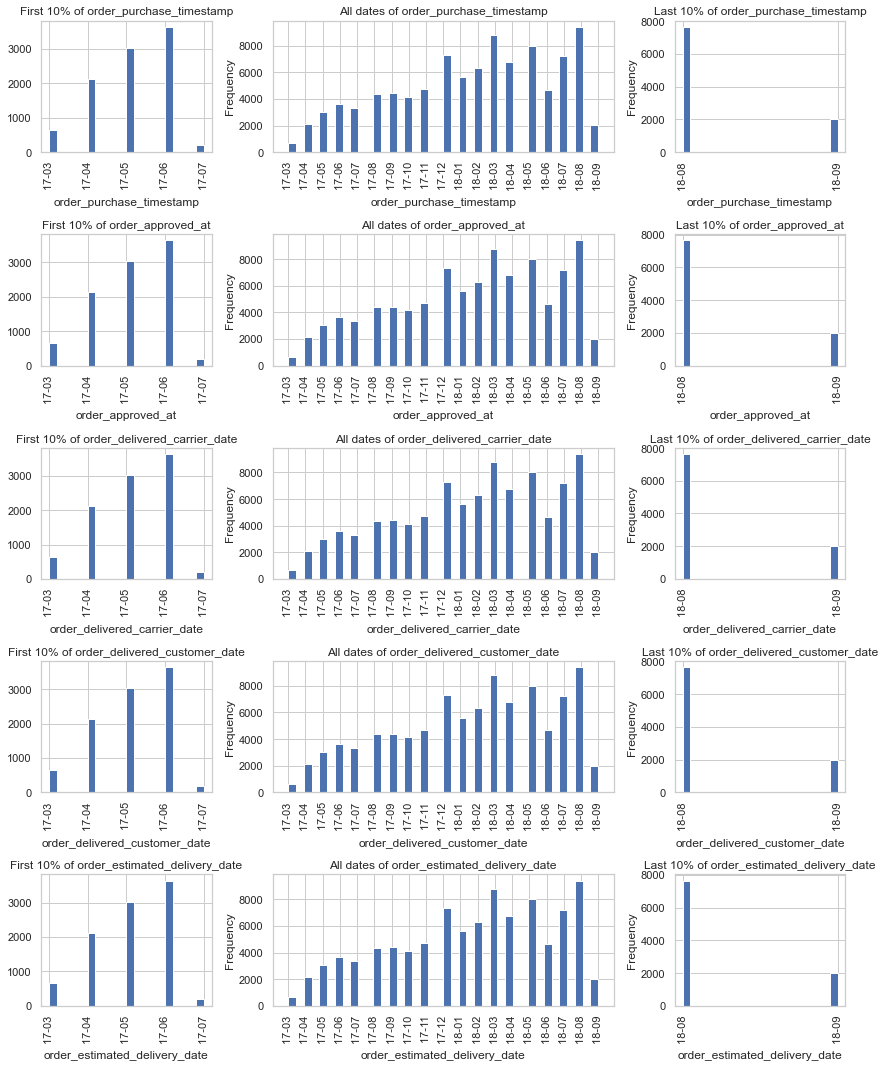

In [374]:
data_order_visualization = data_orders[data_orders_date_columns]


fig, axs = plt.subplots(len(data_orders_date_columns),3,gridspec_kw={'width_ratios': [2, 4, 2]}, figsize=(12,15))

for i, columns in enumerate(data_orders_date_columns):
    
    sorted_dates = pd.to_datetime(data_order_visualization[column]).dt.strftime(' %y-%m')
    sorted_dates = sorted_dates.sort_values(ascending=True)
    hundred_first_dates = sorted_dates.head(round(len(sorted_dates)*0.1))
    hundred_last_dates = sorted_dates.tail(round(len(sorted_dates)*0.1))

    axs[i,0].hist(hundred_first_dates, bins=20)
    axs[i,0].set_title('First 10% of ' + columns)
    axs[i,0].set_xlabel(columns)
    axs[i,0].tick_params(axis='x', rotation=90)

    axs[i,1].hist(sorted_dates, bins=40)
    axs[i,1].set_title('All dates of ' + columns)
    axs[i,1].set_xlabel(columns)
    axs[i,1].set_ylabel('Frequency')
    axs[i,1].tick_params(axis='x', rotation=90)

    axs[i,2].hist(hundred_last_dates, bins=20)
    axs[i,2].set_title('Last 10% of ' + columns)
    axs[i,2].set_xlabel(columns)
    axs[i,2].set_ylabel('Frequency')
    axs[i,2].tick_params(axis='x', rotation=90)

plt.tight_layout()
print(fig)

# Feature extraction

Feuille de route :

1. Faire un premier jeu de variables avec RFM --> Date de la dernière commande | Nombre de commandes | Total dépensé
2. Faire le clustering sur ces variables sur une période fixe (toute l'année) puis du flotant
3. Rajouter les features et refaire un clustering
4. Rajouter plusieurs algorithmes
5. Faire de l'interpretation en pensant au point de vue marketing

Features interessantes :
- Temps médian entre les commandes
- Somme médianne des commandes
- Mois avec le plus de commandes (avec une pondération ?)
- Catégorie préférée (attention, variable catégorielle)
- Score moyen des reviews
- "A laissé une review"

Adding new features to a custom dataframe representing a customer.
Adding :
- **Recency** (How recently did the customer purchase?) : When was the last order
- **Frequency** (How often do they purchase?) : Average time between orders (time signed up / number of orders)
- **Monetary Value** (How much do they spend?) : What is the median of the order value
- **number of orders** : How many orders the customer has made.
- **customer's seniority** : How long the customer has been a customer.
- **total spent** : How much the customer has spent
- **prefered category** : What is the prefered category of the customer
- **most spent month** : Month with the most orders
- **average review score** : Average review score of the customer
  
Every date is transformed into a number of days from now. And we consider (even if it isn't mentionned) that the times are in UTC.
Also, in order to calculate the customer's seniority, we consider the current date as the 01/01/2019 because the dataset gathers data from 2016 to 2018.

In [375]:
custom_customers_df = data_customer.drop(['customer_zip_code_prefix', 'customer_city', 'customer_state', 'customer_id'], axis=1).drop_duplicates()

## Recency

**Recency** (How recently did the customer purchase?) : When was the last order

In [376]:
from datetime import datetime

# Keeping the relation from order customer id and customer unique id
custom_orders_df = data_customer[['customer_unique_id', 'customer_id']]
# Getting the orders details
custom_orders_df = custom_orders_df.merge(data_orders, on='customer_id', how='inner')
# Grouping every customer by their customer_unique_id and selecting the most recent order date (and renaming it)
custom_orders_most_recent_df = custom_orders_df.groupby('customer_unique_id').agg({'order_purchase_timestamp': 'max'}).reset_index()
custom_orders_most_recent_df['Recency'] = (max_datetime - pd.to_datetime(custom_orders_most_recent_df['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')).dt.days
custom_orders_most_recent_df = custom_orders_most_recent_df.drop('order_purchase_timestamp', axis=1)

custom_orders_most_recent_df.sort_values(by='Recency')

# Adding recency column to the custom_customers_df
custom_customers_df = custom_customers_df.merge(custom_orders_most_recent_df, on='customer_unique_id', how='inner')


custom_customers_df

,customer_unique_id,Recency
0,861eff4711a542e4b93843c6dd7febb0,501
1,290c77bc529b7ac935b93aa66c333dc3,260
2,060e732b5b29e8181a18229c7b0b2b5e,133
3,259dac757896d24d7702b9acbbff3f3c,200
4,345ecd01c38d18a9036ed96c73b8d066,62
...,...,...
93288,1a29b476fee25c95fbafc67c5ac95cf8,175
93289,d52a67c98be1cf6a5c84435bd38d095d,178
93290,e9f50caf99f032f0bf3c55141f019d99,174
93291,73c2643a0a458b49f58cea58833b192e,330


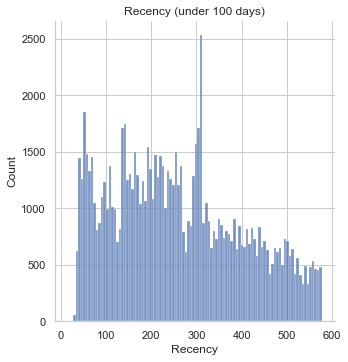

It is very probable that the last registered date was about 75 days before 2019 01 01 because our distribution seems to be skewed to the right.
So we will use a new "now date" of 2*31 = 62 days earlier.


In [377]:
from datetime import timedelta

ax = sns.displot(custom_orders_most_recent_df['Recency'], bins=100)
plt.title('Recency (under 100 days)')
plt.show()
print('It is very probable that the last registered date was about 75 days before 2019 01 01 because our distribution seems to be skewed to the right.\nSo we will use a new "now date" of 2*31 = 62 days earlier.')

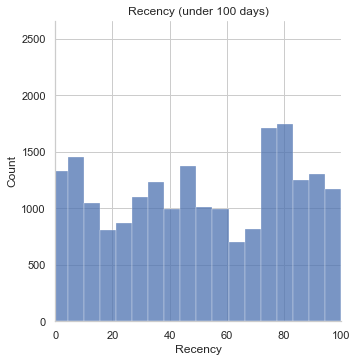

Feels better


In [378]:
now_date = now_date - timedelta(days=62)
custom_orders_most_recent_df['Recency'] = custom_orders_most_recent_df['Recency'] - 62

ax = sns.displot(custom_orders_most_recent_df['Recency'], bins=100)
plt.xlim(0,100)
plt.title('Recency (under 100 days)')
plt.show()
print('Feels better')

## Frequency (and seniority and number of orders)

**Frequency** (How often do they purchase?) : Average time between orders (customer's seniority / number of orders)

**Number of orders** : How many orders the customer has made.

**Customer's seniority** : How long the customer has been a customer.

Because there is no information about one customer's first activity, we will use the first order date as the customer's first activity.

In [379]:
# Reuse of the previous function for getting the most recent order date, but for the oldest order
custom_orders_most_ancient_df = custom_orders_df.groupby('customer_unique_id').agg({'order_purchase_timestamp': 'min'}).reset_index().rename(columns={'order_purchase_timestamp': 'Seniority'})
custom_customers_df = custom_customers_df.merge(custom_orders_most_ancient_df, on='customer_unique_id', how='inner')
custom_customers_df

,customer_unique_id,Recency,Seniority
0,861eff4711a542e4b93843c6dd7febb0,501,2017-05-16 15:05:35
1,290c77bc529b7ac935b93aa66c333dc3,260,2018-01-12 20:48:24
2,060e732b5b29e8181a18229c7b0b2b5e,133,2018-05-19 16:07:45
3,259dac757896d24d7702b9acbbff3f3c,200,2018-03-13 16:06:38
4,345ecd01c38d18a9036ed96c73b8d066,62,2018-07-29 09:51:30
...,...,...,...
93288,1a29b476fee25c95fbafc67c5ac95cf8,175,2018-04-07 15:48:17
93289,d52a67c98be1cf6a5c84435bd38d095d,178,2018-04-04 08:20:22
93290,e9f50caf99f032f0bf3c55141f019d99,174,2018-04-08 20:11:50
93291,73c2643a0a458b49f58cea58833b192e,330,2017-11-03 21:08:33


In [380]:
orders_per_customer = custom_orders_df['customer_unique_id'].value_counts()
orders_per_customer = pd.DataFrame(orders_per_customer.items(), columns=['customer_unique_id', 'number_of_orders'])
custom_customers_df = custom_customers_df.merge(orders_per_customer, on='customer_unique_id', how='inner')
custom_customers_df

,customer_unique_id,Recency,Seniority,number_of_orders
0,861eff4711a542e4b93843c6dd7febb0,501,2017-05-16 15:05:35,1
1,290c77bc529b7ac935b93aa66c333dc3,260,2018-01-12 20:48:24,1
2,060e732b5b29e8181a18229c7b0b2b5e,133,2018-05-19 16:07:45,1
3,259dac757896d24d7702b9acbbff3f3c,200,2018-03-13 16:06:38,1
4,345ecd01c38d18a9036ed96c73b8d066,62,2018-07-29 09:51:30,1
...,...,...,...,...
93288,1a29b476fee25c95fbafc67c5ac95cf8,175,2018-04-07 15:48:17,1
93289,d52a67c98be1cf6a5c84435bd38d095d,178,2018-04-04 08:20:22,1
93290,e9f50caf99f032f0bf3c55141f019d99,174,2018-04-08 20:11:50,1
93291,73c2643a0a458b49f58cea58833b192e,330,2017-11-03 21:08:33,1
